In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

In [4]:
df=pd.read_csv('metabolites_transformed.csv')
df=df.drop(columns=['Sample'])
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr
corr_features = correlation(df, 0.95)
df = df.drop(corr_features, axis=1)
n_features3 = df.shape[1]
print(f'After removing {len(corr_features)} features, there are {n_features3} features left.')
df.to_csv('corr_metabolites2.csv',index=False)

After removing 39 features, there are 564 features left.


In [7]:
df1=pd.read_csv('albion_with_time_diagnosis_final.csv')
print(df1.shape)
df2=pd.read_csv('corr_metabolites2.csv')
print(df2.shape)
filtered_df1 = df1[df1['VisitNuA'] == 1.0]

# Step 2: Merge the DataFrames with different ID column names
merged_df = filtered_df1.merge(df2, left_on='ID', right_on='Client CODE', how='inner')

print(merged_df)
print(merged_df.shape)
merged_df.to_csv('albion_timediagnosis_and_metabolites.csv',index=False)

(584, 193)
(178, 564)
     SEX   Age  VisitNuA   EDU  WorkStat  MH2  MH6  MH7  MH8  MH9  ...  \
0      2  69.0         1  12.0       3.0  0.0  0.0  0.0  1.0  1.0  ...   
1      2  71.0         1   6.0       1.0  1.0  0.0  0.0  1.0  0.0  ...   
2      1  64.0         1  15.0       3.0  1.0  0.0  1.0  1.0  1.0  ...   
3      1  72.0         1  10.0       3.0  0.0  0.0  1.0  1.0  0.0  ...   
4      2  53.0         1  12.0       3.0  0.0  0.0  0.0  1.0  1.0  ...   
..   ...   ...       ...   ...       ...  ...  ...  ...  ...  ...  ...   
171    2  54.0         1  13.0       1.0  0.0  0.0  0.0  0.0  0.0  ...   
172    2  56.0         1  14.0       4.0  0.0  0.0  0.0  0.0  0.0  ...   
173    1  49.0         1  14.0       1.0  0.0  0.0  0.0  0.0  0.0  ...   
174    2  55.0         1  16.0       3.0  1.0  0.0  0.0  0.0  1.0  ...   
175    2  62.6         1  18.0       1.0  0.0  0.0  0.0  0.0  0.0  ...   

     LPC(O-24:2)  LPC(P-16:0)  LPC(P-18:0)  LPC(P-18:1)  LPE(P-16:0)  \
0      -0.638510 

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
log_reg = RandomForestClassifier(n_estimators=500, n_jobs=-1)
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
df=pd.read_csv('albion_timediagnosis_and_metabolites.csv')
df=df.drop(columns=['ID','Client CODE','TIME_DIAGNOSIS'])
X=df.drop(columns=['DIAGNOSIS'])
y=df['DIAGNOSIS']
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0,stratify=y)


# Define Stratified K-Fold
rfecv = RFECV(estimator=log_reg, step=1, cv=10, scoring=make_scorer(f1_score, average='macro', greater_is_better=True))
rfecv.fit(X_train, y_train)
print('Optimal number of features: {}'.format(rfecv.n_features_))
y_test_pred = rfecv.predict(X_test)
print(classification_report(y_test,y_test_pred))
print(rfecv.get_support(indices=True))  

(176, 753)
Optimal number of features: 19
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        24
           1       1.00      0.83      0.91        12

    accuracy                           0.94        36
   macro avg       0.96      0.92      0.93        36
weighted avg       0.95      0.94      0.94        36

[ 38  43  65  68  75  76  78  97 104 108 111 115 125 130 131 140 141 171
 540]


In [12]:
indices = [38 , 43 , 65 , 68 , 75  ,76,  78 , 97, 104, 108, 111 ,115 ,125, 130, 131, 140, 141, 171,540]
for i in indices:
    print(X_test.columns[i])

CDR1
CDR_TOT
MEMORY
EXECUTIVE
ACE
MMSE
ACE_MEMORY
ll5cor1
ll7cor1
ll8cor1
ll9cor1
ll10cor1
TMTA_tmtAtime
figureimmediate
figuredelayed
history1
history2
Sum1_5correct1st
PE(P-20:0/18:2)


In [4]:
df=pd.read_csv('albion_timediagnosis_and_metabolites.csv')

stop_column = 'number_of_recalls'  # Normalize until column 'D' (exclusive)
exclude_columns = ['DIAGNOSIS','TIME_DIAGNOSIS']  # Exclude column 'B'

# Get the list of columns to normalize
columns_to_normalize = [col for col in df.columns if col not in exclude_columns and df.columns.get_loc(col) < df.columns.get_loc(stop_column)]

# Apply normalization (Z-score) to the selected columns
df[columns_to_normalize] = (df[columns_to_normalize] - df[columns_to_normalize].mean()) / df[columns_to_normalize].std()

print(df['DIAGNOSIS'])
print(df['Age'])
df.to_csv('normalized_albion_metabolites_with_time_excl_some.csv',index=False)

0      0
1      0
2      1
3      1
4      1
      ..
171    0
172    0
173    1
174    1
175    0
Name: DIAGNOSIS, Length: 176, dtype: int64
0      0.537771
1      0.757831
2     -0.012378
3      0.867861
4     -1.222708
         ...   
171   -1.112678
172   -0.892618
173   -1.662828
174   -1.002648
175   -0.166420
Name: Age, Length: 176, dtype: float64


In [15]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection  import train_test_split
from sklearn.linear_model import LogisticRegression
df=pd.read_csv('normalized_albion_metabolites_with_time_excl_some.csv')
df=df.drop(columns=['VisitNuA','NPI2','NPI12'])
print(df['DIAGNOSIS'])
df=df.drop(columns=['Client CODE','ID','TIME_DIAGNOSIS'])
X=df.drop(columns=['DIAGNOSIS'])
y=df['DIAGNOSIS']

X_train,X_test,y_train,y_test =train_test_split(X,y,test_size=0.2,
random_state=42,stratify=y,shuffle=True)
linearreg = LogisticRegression(max_iter=50000,solver='saga')
forwad = SequentialFeatureSelector(
linearreg,
k_features=50,
forward=True,
verbose=1,
n_jobs=-1,
scoring="accuracy"
)
sf = forwad.fit(X_train,y_train)
feat_names = list(sf.k_feature_names_)
print(feat_names)

print(sf.k_feature_idx_)

0      0
1      0
2      1
3      1
4      1
      ..
171    0
172    0
173    1
174    1
175    0
Name: DIAGNOSIS, Length: 176, dtype: int64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 735 out of 750 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    4.6s finished
Features: 1/50[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 749 out of 749 | elapsed:    2.0s finished
Features: 2/50[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 748 out of 748 | elapsed:    1.8s finished
Features: 3/50[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 747 out of 747 | elapsed:    2.1s finished
Features: 4/50[Parallel(n_jobs=-1)]: Usin

['SEX', 'EDU', 'MH6', 'MH7', 'MH9', 'MH10', 'MH20', 'MH21', 'MED1', 'MED3', 'MED5', 'MED9', 'MED10', 'MED18', 'MED23', 'FH1', 'FH3', 'FH8', 'FH9', 'NPI4', 'NPI7', 'NPI9', 'NPI_TOT', 'CDR2', 'CDR5', 'IADL1', 'IADL2', 'IADL4', 'IADL5', 'IADL6', 'IADL7', 'IADL8', 'HACH4', 'UPDRS2', 'UPDRS4a', 'UPDRS4b', 'UPDRS5c', 'UPDRS7b', 'UPDRS10', 'MEMORY', 'LANGUAGE', 'ATTENTION', 'EXECUTIVE', 'VISUOSPATIONAL', 'DIAG_VADposs', 'DIAG_FTDbv', 'DIAG_PDprob', 'ACE_ATTENTION', 'll7cor1', 'Iminodiacetic acid']
(0, 2, 5, 6, 8, 9, 11, 12, 14, 15, 17, 19, 20, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 39, 41, 42, 44, 45, 46, 47, 48, 50, 53, 54, 55, 56, 57, 58, 62, 63, 64, 65, 66, 68, 69, 71, 74, 101, 269)


In [25]:
linearreg = LogisticRegression(solver='saga',max_iter=20000)
forwad = SequentialFeatureSelector(
linearreg,
k_features=50,
forward=False,
verbose=1,
scoring="accuracy",
n_jobs=-1
)
sf = forwad.fit(X_train,y_train)
feat_names = list(sf.k_feature_names_)
print(feat_names)

print(sf.k_feature_idx_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

TypeError: 'NoneType' object is not iterable

In [23]:
# Define Stratified K-Fol
# from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix

from sklearn.feature_selection import RFECV
log_reg = LogisticRegression(max_iter=20000,n_jobs=-1,C=0.1)

from sklearn.datasets import make_classification
rfecv = RFECV(estimator=log_reg, step=1, cv=10, scoring='accuracy')
        
rfecv.fit(X_train, y_train)
print('Optimal number of features: {}'.format(rfecv.n_features_))
y_test_pred = rfecv.predict(X_test)
print(classification_report(y_test,y_test_pred))
print(rfecv.get_support(indices=True))  

Optimal number of features: 4
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.92      0.96        12

    accuracy                           0.97        36
   macro avg       0.98      0.96      0.97        36
weighted avg       0.97      0.97      0.97        36

[ 62  65  72 105]


In [24]:
indices = [62,65,72,105]
for i in indices:
    print(X.columns[i])

MEMORY
EXECUTIVE
ACE
ll8cor1


0      0
1      0
2      1
3      1
4      1
      ..
171    0
172    0
173    1
174    1
175    0
Name: DIAGNOSIS, Length: 176, dtype: int64
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 46, number of negative: 94
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27792
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 687
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328571 -> initscore=-0.714653
[LightGBM] [Info] Start training from score -0.714653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

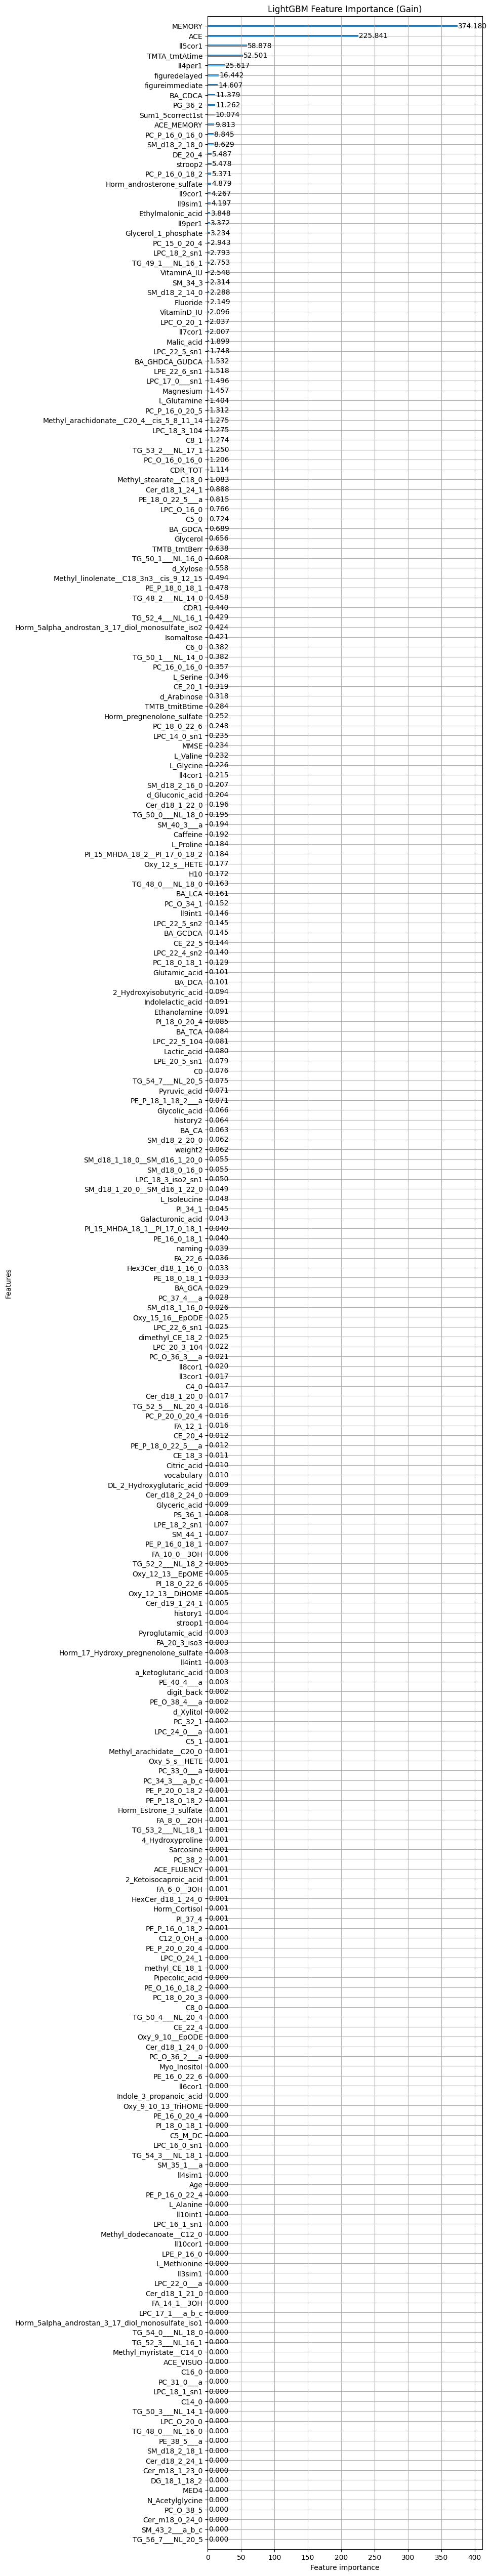

In [38]:
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection  import train_test_split

import re


from sklearn.linear_model import LogisticRegression
df=pd.read_csv('normalized_albion_metabolites_with_time_excl_some.csv',encoding='utf-8')
df=df.drop(columns=['VisitNuA','NPI2','NPI12'])
print(df['DIAGNOSIS'])

df=df.drop(columns=['Client CODE','ID','TIME_DIAGNOSIS'])
X=df.drop(columns=['DIAGNOSIS'])
y=df['DIAGNOSIS']
X.columns = X.columns.str.replace(r'[^a-zA-Z0-9]', ' ', regex=True)  # Replace symbols with space
X.columns = X.columns.str.strip()  # Remove leading/trailing spaces
X.columns = X.columns.astype(str) 
X=X.drop(columns=['mis','mis'])
X_train,X_test,y_train,y_test =train_test_split(X,y,test_size=0.2,
random_state=42,stratify=y,shuffle=True)
X.to_csv('testingXgbm.csv')
train_data = lgb.Dataset(X_train, label = y_train)
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "learning_rate" : 0.1
}
model = lgb.train(params, train_data, num_boost_round=200)
lgb.plot_importance(model, importance_type="gain", figsize=(7,65), title="LightGBM Feature Importance (Gain)")
plt.show()

C:\Users\sothr\AppData\Local\Temp\ipykernel_13956\3571161779.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


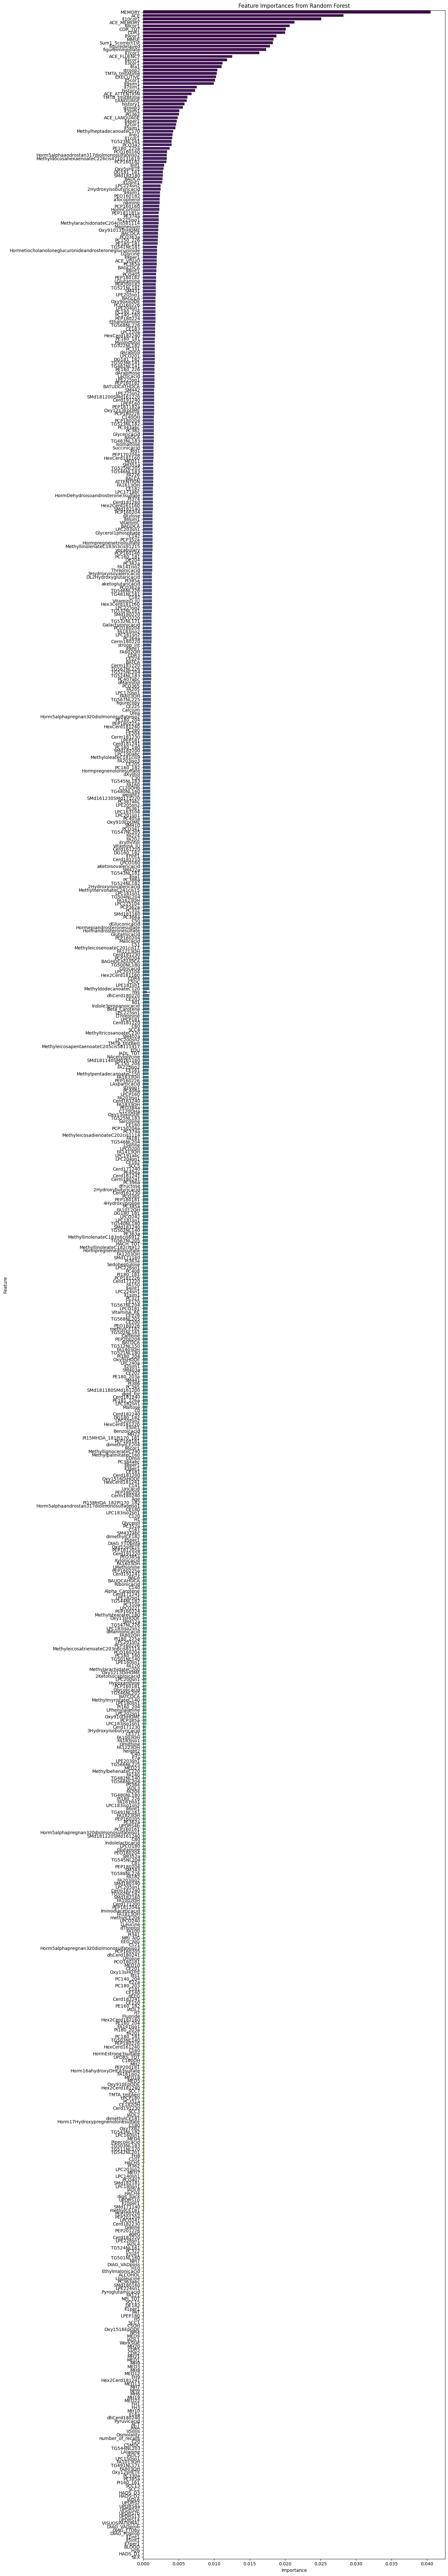

In [10]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(X_train, y_train)

importances = clf.feature_importances_
features = X.columns

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(14, 80))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

0      0
1      0
2      1
3      1
4      1
      ..
171    0
172    0
173    1
174    1
175    0
Name: DIAGNOSIS, Length: 176, dtype: int64


c:\Users\sothr\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\sothr\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\sothr\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\sothr\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

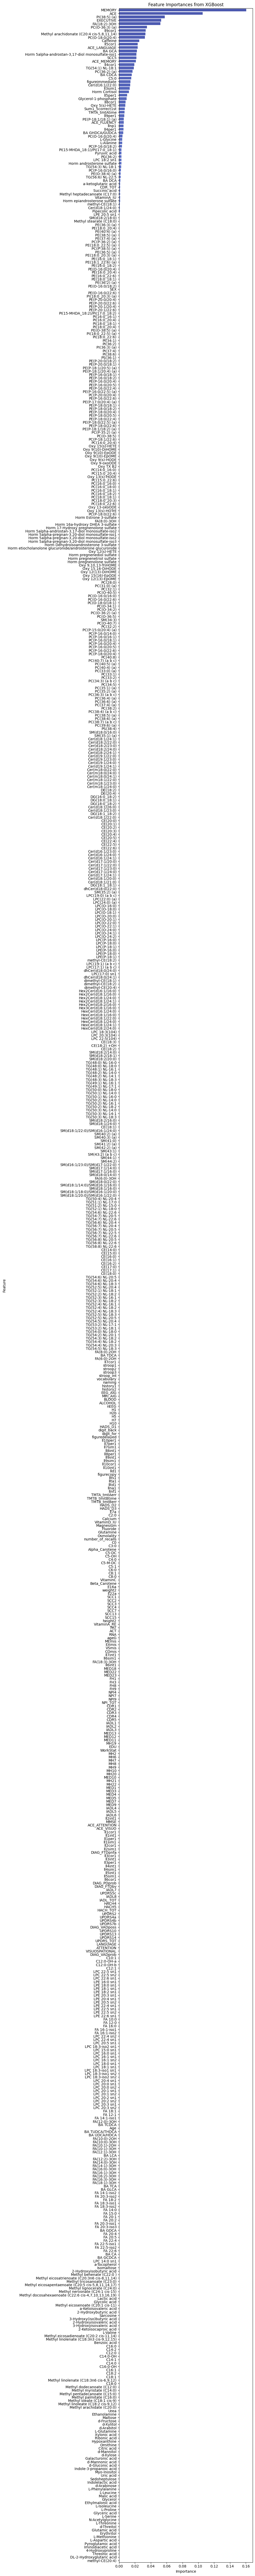

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier


# Train XGBoost Classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
df=pd.read_csv('normalized_albion_metabolites_with_time_excl_some.csv')
df=df.drop(columns=['VisitNuA','NPI2','NPI12'])
print(df['DIAGNOSIS'])
df=df.drop(columns=['Client CODE','ID','TIME_DIAGNOSIS'])

X=df.drop(columns=['DIAGNOSIS'])
y=df['DIAGNOSIS']
X.columns = X.columns.str.replace(r'[\[\]<]', '', regex=True)  # Remove special characters

X_train,X_test,y_train,y_test =train_test_split(X,y,test_size=0.2,
random_state=42,stratify=y,shuffle=True)
model.fit(X_train, y_train)

# Extract Feature Importances
importances = model.feature_importances_
features = X.columns

# Create DataFrame for Visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 100))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='coolwarm')
plt.title('Feature Importances from XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
